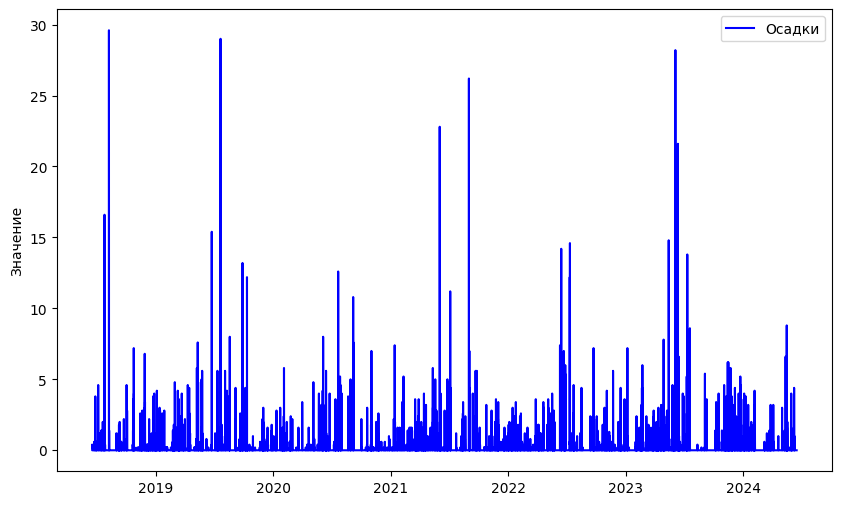

Train X shape: (42035, 1, 3)
Train Y shape: (42035,)
Test X shape: (10509, 1, 3)
Test Y shape: (10509,)


C:\Users\Счастливый Наиль\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - loss: 3.8908e-04 - root_mean_squared_error: 0.0191 - val_loss: 3.2132e-04 - val_root_mean_squared_error: 0.0179
Epoch 2/20
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 2.0769e-04 - root_mean_squared_error: 0.0143 - val_loss: 3.3113e-04 - val_root_mean_squared_error: 0.0182
Epoch 3/20
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 2.1349e-04 - root_mean_squared_error: 0.0146 - val_loss: 3.2119e-04 - val_root_mean_squared_error: 0.0179
Epoch 4/20
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 1.9522e-04 - root_mean_squared_error: 0.0138 - val_loss: 3.3123e-04 - val_root_mean_squared_error: 0.0182
Epoch 5/20
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 2.3865e-04 - root_mean_squared_error: 0.0154 - val_loss: 3.1363e-04 - val_root_mean_squared_error: 0.0177
Epoch 6/20
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 2.2951e-04 - root_mean_squared_error: 0.0151 - val_loss: 3.2422e-04 - val_root_mean_squared_erro

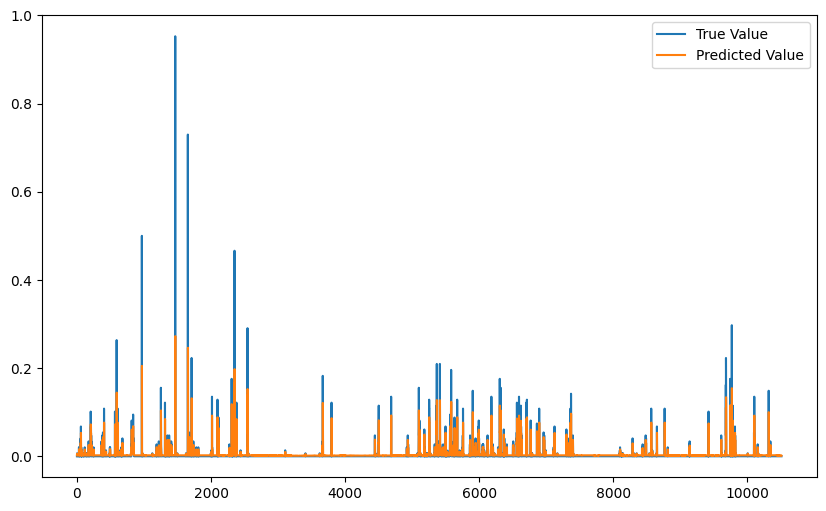

In [9]:
# Import necessary libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

# Load the data
df = pd.read_csv("meteo_data.csv")
df.index = pd.to_datetime(df.DATE)
del df['DATE']

required_cols = ['PRECIPITATION','HC_RELATIVE_HUMIDITY', 'DEW_POINT']
df = df[required_cols]

# Plot the precipitation
plt.figure(figsize=(10, 6))
plt.plot(df['PRECIPITATION'], label='Осадки', color='blue')
plt.ylabel('Значение')
plt.legend()
plt.show()

# Normalize the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Define sequence length and features
sequence_length = 1  # Number of time steps in each sequence
num_features = len(df.columns)

# Create sequences and corresponding labels
sequences = []
labels = []
for i in range(len(scaled_data) - sequence_length):
    seq = scaled_data[i:i+sequence_length]
    label = scaled_data[i+sequence_length][0]  # Predicting precipitation
    sequences.append(seq)
    labels.append(label)

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split into train and test sets
train_size = int(0.8 * len(sequences))
train_x, test_x = sequences[:train_size], sequences[train_size:]
train_y, test_y = labels[:train_size], labels[train_size:]

print("Train X shape:", train_x.shape)
print("Train Y shape:", train_y.shape)
print("Test X shape:", test_x.shape)
print("Test Y shape:", test_y.shape)

# Build the LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(sequence_length, num_features)),
    LSTM(64, return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=[RootMeanSquaredError()])

# Define callbacks
checkpoint = ModelCheckpoint('model2/model2-PRECIPITATION.keras', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    train_x, train_y,
    validation_data=(test_x, test_y),
    epochs=20,
    batch_size=32,
    callbacks=[checkpoint, early_stopping]
)

# Load the best model
model.load_weights('model2/model2-PRECIPITATION.keras')

# Evaluate the model
train_predictions = model.predict(train_x)
test_predictions = model.predict(test_x)

print("Train MAE:", mean_absolute_error(train_y, train_predictions))
print("Test MAE:", mean_absolute_error(test_y, test_predictions))
print("Train MSE:", mean_squared_error(train_y, train_predictions))
print("Test MSE:", mean_squared_error(test_y, test_predictions))
print("Train R2 Score:", r2_score(train_y, train_predictions))
print("Test R2 Score:", r2_score(test_y, test_predictions))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(test_y, label='True Value')
plt.plot(test_predictions, label='Predicted Value')
plt.legend()
plt.show()


In [ ]:
import numpy as np
import pandas as pd

def predict_future(model, last_known_data, last_known_dates, steps=3, window_size=10):
    """
    Функция для предсказания будущих значений осадков на основе модели LSTM.
    
    Аргументы:
    model -- обученная модель LSTM
    last_known_data -- последние известные данные о осадках, точке росы и относительной влажности
    last_known_dates -- последние известные даты
    steps -- количество шагов вперед для предсказания
    window_size -- размер окна последовательности для предсказания

    Возвращает:
    future_dates -- даты предсказанных значений
    predictions -- предсказанные значения осадков
    """
    predictions = []
    future_dates = pd.date_range(start=last_known_dates[-1], periods=steps + 1, freq='h')[1:]

    current_data = last_known_data.tolist()

    for _ in range(steps):
        input_data = np.array(current_data[-window_size:]).reshape(1, window_size, 3)
        prediction = model.predict(input_data)
        predictions.append(prediction[0, 0])
        
        # Добавляем новое предсказанное значение в список текущих данных
        next_data = current_data[-1].copy()
        next_data[0] = prediction[0, 0]  # Обновляем осадки
        current_data.append(next_data)
    
    return future_dates, predictions

# Последние известные данные и даты
WINDOW_SIZE = 10
last_known_data = df.values[-WINDOW_SIZE:]
last_known_dates = df.index[-WINDOW_SIZE:]

# Прогнозирование на 3 шага вперед
future_steps = 24
future_dates, predictions = predict_future(model, last_known_data, last_known_dates, future_steps, WINDOW_SIZE)

# Вывод предсказаний с датами
for date, pred in zip(future_dates, predictions):
    print(f"{date}: {pred}")
